In [1]:
import matplotlib.pyplot as plt
import skimage.io as io
from glob import glob

import numpy as np
import random as r

In [2]:
files = glob("data\\dataset\\MICCAI_BraTS_2019_Data_Training\\" + "**\\*flair.nii.gz", recursive=True)

files

['data\\dataset\\MICCAI_BraTS_2019_Data_Training\\HGG\\BraTS19_2013_10_1\\BraTS19_2013_10_1_flair.nii.gz',
 'data\\dataset\\MICCAI_BraTS_2019_Data_Training\\HGG\\BraTS19_2013_11_1\\BraTS19_2013_11_1_flair.nii.gz',
 'data\\dataset\\MICCAI_BraTS_2019_Data_Training\\HGG\\BraTS19_2013_12_1\\BraTS19_2013_12_1_flair.nii.gz',
 'data\\dataset\\MICCAI_BraTS_2019_Data_Training\\HGG\\BraTS19_2013_13_1\\BraTS19_2013_13_1_flair.nii.gz',
 'data\\dataset\\MICCAI_BraTS_2019_Data_Training\\HGG\\BraTS19_2013_14_1\\BraTS19_2013_14_1_flair.nii.gz',
 'data\\dataset\\MICCAI_BraTS_2019_Data_Training\\HGG\\BraTS19_2013_17_1\\BraTS19_2013_17_1_flair.nii.gz',
 'data\\dataset\\MICCAI_BraTS_2019_Data_Training\\HGG\\BraTS19_2013_18_1\\BraTS19_2013_18_1_flair.nii.gz',
 'data\\dataset\\MICCAI_BraTS_2019_Data_Training\\HGG\\BraTS19_2013_19_1\\BraTS19_2013_19_1_flair.nii.gz',
 'data\\dataset\\MICCAI_BraTS_2019_Data_Training\\HGG\\BraTS19_2013_20_1\\BraTS19_2013_20_1_flair.nii.gz',
 'data\\dataset\\MICCAI_BraTS_2019_Da

In [3]:
len(files)

335

# Convert to Array

In [4]:
first_img = io.imread(files[1], plugin="simpleitk")

print(f"shape: {first_img.shape}")
print(f"dtype: {first_img.dtype}")

shape: (155, 240, 240)
dtype: int16


## Visualize Flair Image

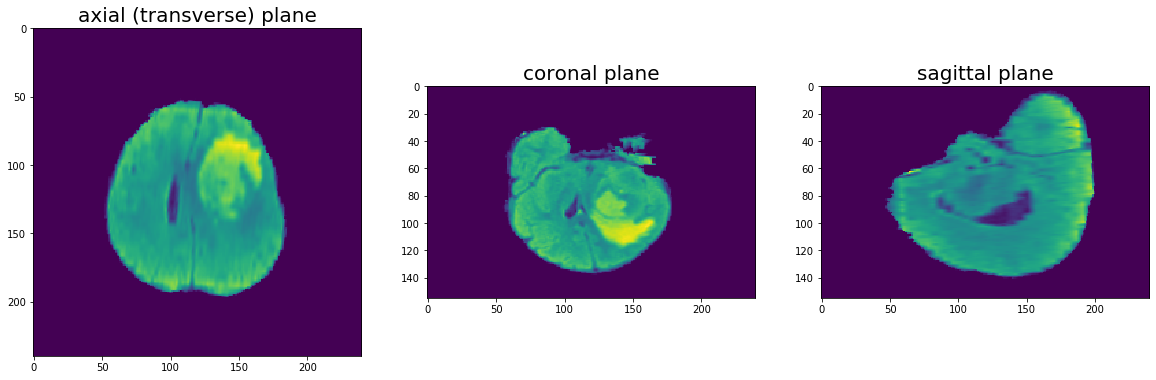

In [5]:
fig = plt.figure(figsize=(20,15))

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(first_img[100,:,:])
plt.title("axial (transverse) plane", fontsize=20)

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(first_img[:,100,:])
plt.title("coronal plane", fontsize=20)

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(first_img[:,:,100])
plt.title("sagittal plane", fontsize=20);

## Visualize Segmented Image

In [6]:
files[1]

'data\\dataset\\MICCAI_BraTS_2019_Data_Training\\HGG\\BraTS19_2013_11_1\\BraTS19_2013_11_1_flair.nii.gz'

In [7]:
seg_img = io.imread('data\\dataset\\MICCAI_BraTS_2019_Data_Training\\HGG\\BraTS19_2013_11_1\\BraTS19_2013_11_1_seg.nii.gz', plugin="simpleitk")

print(f"shape: {seg_img.shape}")
print(f"dtype: {seg_img.dtype}")

shape: (155, 240, 240)
dtype: int16


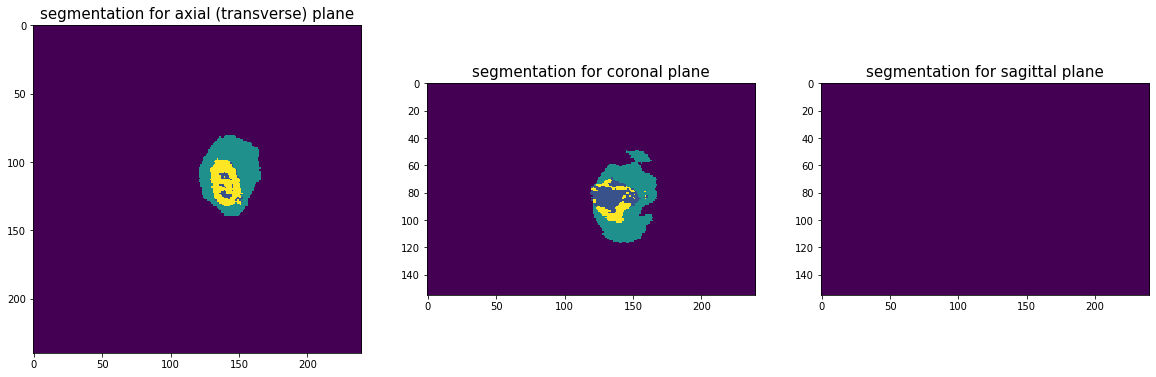

In [8]:
fig = plt.figure(figsize=(20,15))

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(seg_img[100,:,:])
plt.title("segmentation for axial (transverse) plane", fontsize=15)

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(seg_img[:,100,:])
plt.title("segmentation for coronal plane", fontsize=15)

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(seg_img[:,:,100])
plt.title("segmentation for sagittal plane", fontsize=15);

In [9]:
def to_array(path, end):
    
    # get locations
    files = glob(path+end, recursive=True)
    
    img_list = []
    
    r.seed(42)
    r.shuffle(files)
    
    for file in files:
        img = io.imread(file, plugin="simpleitk")

        img = np.resize(img, (120,120,120))

        # standardization
        img = (img-img.mean())/img.std()
        img.astype("float32")
        
        for slice in range(60, 70):
            img_s = img[slice,:,:]
            img_s = np.expand_dims(img_s, axis=0)
            img_list.append(img_s)
            
    return np.array(img_list,np.float32)

In [10]:
first_img.shape

(155, 240, 240)

In [11]:
exp = first_img[60,:,:]

exp.shape

(240, 240)

In [12]:
exp = np.expand_dims(exp, axis=0)

exp.shape

(1, 240, 240)

# Applying the Function

In [13]:
train = to_array(path="data\\dataset\\MICCAI_BraTS_2019_Data_Training\\", end="**\\*flair.nii.gz")

In [14]:
train.shape

(3350, 1, 120, 120)

# Segmented Images

1 - Non-enhancing Tumor

2 - Edema 

4 - Enhancing Tumor

In [15]:
seg_img.shape

(155, 240, 240)

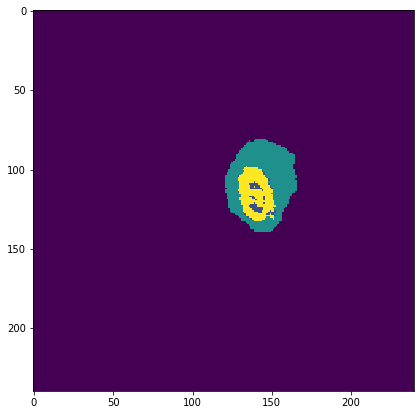

In [16]:
plt.figure(figsize=(7,7))
plt.imshow(seg_img[100,:,:]);

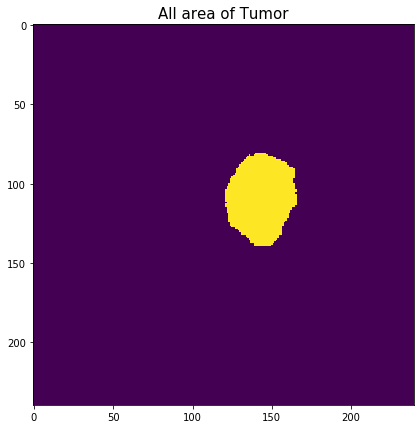

In [17]:
seg_all = seg_img.copy()

seg_all[seg_all != 0] = 1 # show all tumor area

plt.figure(figsize=(7,7))
plt.imshow(seg_all[100,:,:])
plt.title("All area of Tumor", fontsize=15);

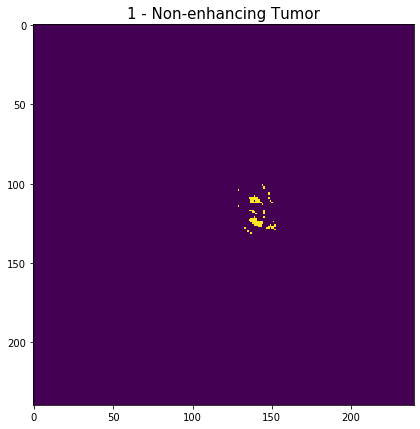

In [18]:
seg_non = seg_img.copy()

seg_non[seg_non != 1] = 0 # show non-enhancing tumor

plt.figure(figsize=(7,7))
plt.imshow(seg_non[100,:,:])
plt.title("1 - Non-enhancing Tumor", fontsize=15);

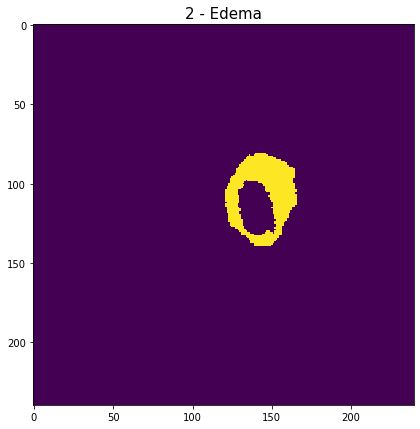

In [19]:
seg_edema = seg_img.copy()

seg_edema[seg_edema == 1] = 0 # cover Non-enhancing Tumor
seg_edema[seg_edema == 4] = 0 # cover Enhancing Tumor
seg_edema[seg_edema != 0] = 1 # show Edema

plt.figure(figsize=(7,7))
plt.imshow(seg_edema[100,:,:])
plt.title("2 - Edema", fontsize=15);

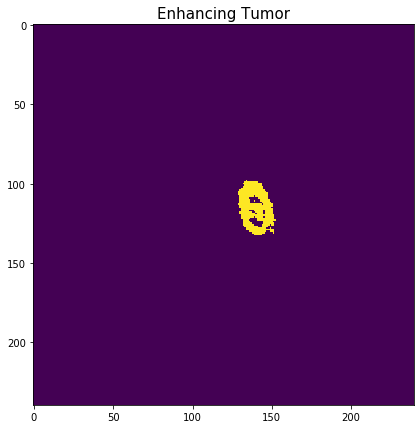

In [20]:
seg_enhancing = seg_img.copy()

seg_enhancing[seg_enhancing != 4] = 0 # show Enhancing Tumor

plt.figure(figsize=(7,7))
plt.imshow(seg_enhancing[100,:,:])
plt.title("Enhancing Tumor", fontsize=15);

# To Array for Segmented Images

In [21]:
def seg_to_array(path, end, label):
    
    # get locations
    files = glob(path+end, recursive=True)
    
    img_list = []
    
    r.seed(42)
    r.shuffle(files)
    
    for file in files:
        img = io.imread(file, plugin="simpleitk")

        img = np.resize(img, (120,120,120))
        
        # all tumor
        if label == 1:
            img[img != 0] = 1
        
        # Non-enhancing Tumor
        if label == 2:
            img[img != 1] = 0
        
        # Without Edema
        if label == 3:
            img[img == 2] = 0
            img[img != 0] = 1
        
        # Enhancing Tumor
        if label == 4:
            img[img != 4] = 0
            img[img == 4] = 1
            

        img.astype("float32")
        
        for slice in range(60, 70):
            img_s = img[slice,:,:]
            img_s = np.expand_dims(img_s, axis=0)
            img_list.append(img_s)
            
    return np.array(img_list,np.float32)

In [22]:
seg_all_tumor = seg_to_array(path="data\\dataset\\MICCAI_BraTS_2019_Data_Training\\", end="**\\*seg.nii.gz", label=1)

seg_non_enhancing = seg_to_array(path="data\\dataset\\MICCAI_BraTS_2019_Data_Training\\", end="**\\*seg.nii.gz", label=2)

seg_out_edema = seg_to_array(path="data\\dataset\\MICCAI_BraTS_2019_Data_Training\\", end="**\\*seg.nii.gz", label=3) 

seg_enhancing = seg_to_array(path="data\\dataset\\MICCAI_BraTS_2019_Data_Training\\", end="**\\*seg.nii.gz", label=4) 

seg_original = seg_to_array(path="data\\dataset\\MICCAI_BraTS_2019_Data_Training\\", end="**\\*seg.nii.gz", label=0) 

In [23]:
seg_all_tumor.shape

(3350, 1, 120, 120)

In [24]:
seg_non_enhancing.shape

(3350, 1, 120, 120)